In [1]:
from fastai.tabular.all import *
import pandas as pd

## Heart failure dataset

In [2]:
df = pd.read_csv('heart.csv')

In [3]:
len(df)

299

In [4]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [5]:
df = df.drop(['time'], axis=1)

In [6]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'DEATH_EVENT'],
      dtype='object')

## Neural Network

In [7]:
cont_names = ['age','creatinine_phosphokinase','ejection_fraction','platelets',
            'serum_creatinine','serum_sodium']
cat_names = ['anaemia','diabetes','high_blood_pressure','sex', 'smoking']
y_names = 'DEATH_EVENT'
y_block = CategoryBlock()
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))
procs = [Categorify, FillMissing, Normalize]

In [8]:
to = TabularPandas(df, procs=procs, cat_names=cat_names,
                   cont_names=cont_names, y_names=y_names,
                   y_block=y_block, splits=splits)

In [9]:
dls = to.dataloaders(bs=128)

In [10]:
dls.show_batch()

,anaemia,diabetes,high_blood_pressure,sex,smoking,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT
0,0,1,0,1,1,70.000000,65.999990,45.000000,249000.000582,0.80,136.0,0
1,0,0,1,1,1,70.000000,582.000001,20.000000,263358.031224,1.83,134.0,1
2,1,1,0,1,0,44.999999,1875.999991,35.000000,225999.999633,0.90,138.0,0
3,0,0,1,0,0,70.000000,1201.999993,50.000000,357999.998058,0.90,141.0,0
4,1,0,1,0,0,70.000000,124.999995,24.999999,236999.999021,1.00,140.0,1
5,0,1,0,1,0,40.000000,582.000001,35.000000,221999.999594,1.00,132.0,0
6,0,1,0,1,0,59.000000,65.999990,20.000000,70000.006736,2.40,134.0,1
7,1,0,0,0,0,70.000000,59.000025,60.000000,254999.999921,1.10,136.0,0
8,1,1,0,0,1,60.000000,260.000008,38.000000,254999.999921,2.20,132.0,1
9,0,1,0,1,1,80.000000,147.999989,38.000000,148999.995266,1.90,144.0,1


In [11]:
learn = tabular_learner(dls, [200,100], metrics=accuracy)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.019054606556892395)

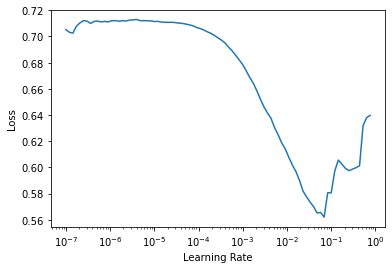

In [12]:
learn.lr_find()

In [13]:
learn.fit(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.713637,0.696055,0.406780,00:00
1,0.688237,0.685620,0.694915,00:00
2,0.668667,0.675043,0.711864,00:00
3,0.648273,0.663420,0.745763,00:00
4,0.632264,0.651046,0.779661,00:00
5,0.613687,0.639027,0.779661,00:00
6,0.597248,0.627060,0.779661,00:00
7,0.586989,0.614194,0.779661,00:00
8,0.579269,0.599821,0.779661,00:00
9,0.572869,0.586654,0.796610,00:00


In [14]:
nn_preds = learn.get_preds()[0]

In [15]:
nn_preds[0]

tensor([0.5706, 0.4294])

In [16]:
dl = learn.dls.valid

In [17]:
val = learn.validate(dl=dl)

In [18]:
print(f' Neural network model accuracy is {val[1]:.2f}%')

 Neural network model accuracy is 0.80%


## Random Forrest

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [21]:
rf = RandomForestClassifier()

In [22]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [23]:
forest_preds = rf.predict_proba(X_test)

In [24]:
forest_preds[0]

array([0.64, 0.36])

In [25]:
score = rf.score(X_test, y_test)

In [26]:
print(f'Random Forrest model accuracy is {score:.2f}%')

Random Forrest model accuracy is 0.76%


## XGBoost

In [27]:
import xgboost as xgb

In [28]:
xgb_model = xgb.XGBClassifier()

In [29]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
xgb_preds = xgb_model.predict_proba(X_test)

In [31]:
xgb_preds[0]

array([0.9451386, 0.0548614], dtype=float32)

In [32]:
xgb_acc = accuracy(tensor(xgb_preds), tensor(y_test))

In [33]:
print(f'XGBoost model accuracyis {xgb_acc:.2f}')

XGBoost model accuracyis 0.66


## Ensembling

In [34]:
avgs = (nn_preds + xgb_preds + forest_preds) / 3

In [35]:
ens_acc = accuracy(tensor(avgs), tensor(y_test))

In [36]:
print(f'Ensebled accuracy for all three models is {ens_acc:.2f}%')

Ensebled accuracy for all three models is 0.71%
